In [1]:
import pyspark
from pyspark.sql.types import DateType
from pyspark.sql import SQLContext, SparkSession, Window
import pyspark.sql.functions
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg
from pyspark.sql.functions import mean, stddev, sqrt
from  math import fabs
from pyspark.sql.functions import sqrt
from scipy.stats import t
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="white")

In [2]:
# Load training data
sc=pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df = sqlContext.read.csv('modeling_raw.csv', header = True)
df = df.select(*(col(c).cast("double").alias(c) for c in df.columns))
df = df.drop('index')

In [7]:
df.head()

Row(Time=124821.0, V1=-0.293294047353316, V2=1.32044132765223, V3=-0.0706281306298108, V4=-0.150199960614059, V5=-0.0766249363966277, V6=-1.7010735644188, V7=0.803095987600071, V8=0.0218390393221945, V9=-0.425571646035132, V10=-0.547928977918683, V11=-0.0386643084288528, V12=1.05235118444437, V13=1.08576743518369, V14=0.563364335036128, V15=0.268944150086187, V16=-0.694488793374962, V17=0.00525428222196361, V18=-0.32539370841395, V19=-0.379186571991734, V20=-0.0959815702300605, V21=0.488085044364057, V22=1.61486788524561, V23=0.0196758203003687, V24=0.943380725885873, V25=-0.859834773652456, V26=-0.273281516328595, V27=0.397604514187768, V28=0.271189039421666, Amount=1.79, Class=0.0)

In [52]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

**VALUE COUNT + DESCRIPTION**

In [53]:
print("\nData shape:")
print((df.count(), len(df.columns)))
print("\nValue counts for data:")
df.groupBy('Class').count().orderBy('count').show()


Data shape:
(226980, 31)

Value counts for data:
+-----+------+
|Class| count|
+-----+------+
|  1.0|   399|
|  0.0|226581|
+-----+------+



In [54]:
df.describe(['V1','V2','V3','V4','V5']).show()
df.describe(['V6','V7','V8','V9','V10']).show()
df.describe(['V11','V12','V13','V14','V15']).show()
df.describe(['V16','V17','V18','V19','V20']).show()
df.describe(['V21','V22','V23','V24','V25']).show()
df.describe(['V26','V27','V28','Amount']).show()

+-------+--------------------+--------------------+-------------------+------------------+--------------------+
|summary|                  V1|                  V2|                 V3|                V4|                  V5|
+-------+--------------------+--------------------+-------------------+------------------+--------------------+
|  count|              226980|              226980|             226980|            226980|              226980|
|   mean|-0.06137635411026...|-0.01776868651763...|0.18468458447183636|0.0412727635253784|-0.06154261401764695|
| stddev|  1.9319492413299244|  1.6528751314013868| 1.4813947394206046|1.4098526174860049|     1.3695054535939|
|    min|    -56.407509631329|   -72.7157275629303|  -33.6809840183525| -5.68317119816995|   -42.1478983728015|
|    max|    2.45492999121121|    22.0577289904909|   9.38255843282114|  16.8753440335975|    34.8016658766686|
+-------+--------------------+--------------------+-------------------+------------------+--------------

**CORRELATION**

In [96]:
features = df.columns
n_features = len(features)
corr = []

for i in range(0, n_features-1):
    temp = [None]*i
    for j in range(i, n_features-1):
        x = df.corr(features[i], features[j])
        temp.append(x)
    corr.append([features[i]] + temp)
    
correlations = sqlContext.createDataFrame(corr, ['Column'] + features[0:29])

In [3]:
df_pd = df.drop('Class')#,'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24', 'V27', 'V28', 'Amount')
df_pd = df_pd.select("*").toPandas()

In [ ]:
g = sns.PairGrid(df_pd, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3)

g.map_upper(sns.regplot)

display(g.fig)

In [91]:
df_pd.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,124821.0,-0.293294,1.320441,-0.070628,-0.150200,-0.076625,-1.701074,0.803096,0.021839,-0.425572,...,-0.095982,0.488085,1.614868,0.019676,0.943381,-0.859835,-0.273282,0.397605,0.271189,1.79
1,44248.0,-1.169041,0.155406,1.905470,-0.292563,-0.279812,0.744489,-0.507951,0.855467,0.556745,...,-0.333976,0.136221,0.396439,0.021329,-0.317360,-0.816541,0.103920,-0.272336,-0.147644,11.50
2,42486.0,-0.606390,0.085921,0.742079,-0.813938,-0.439927,-0.330184,1.499955,-0.024832,-0.841983,...,0.369784,-0.119304,-0.853164,0.584105,0.219285,-0.386169,1.040853,-0.178963,0.000913,220.00
3,76117.0,0.833322,-0.287686,0.213068,1.147570,-0.097010,0.425974,0.012274,0.227463,-0.198350,...,0.047955,0.255148,0.469484,-0.176326,-0.281277,0.422700,-0.251899,0.016901,0.028072,144.00
4,61383.0,0.304884,-2.084781,0.770623,0.889273,-1.474982,1.327165,-0.656441,0.423649,-0.302169,...,0.233049,-0.179009,-0.726258,-0.225310,-0.323963,-0.019856,-0.456912,0.045156,0.097225,435.31


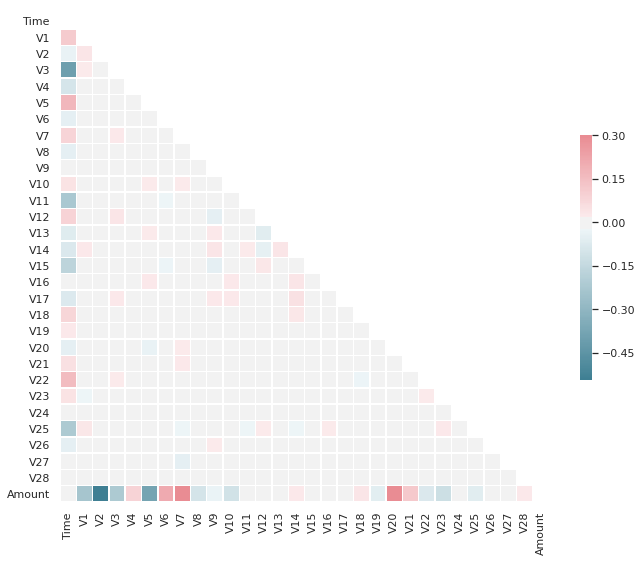

In [95]:
# Compute the correlation matrix
corr = df_pd.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**T-TEST**

p-val(V13, V22, V23, V25, V26) = 0.442, 0.054, 0.147, 0.735, 0.141

In [3]:
df1 =  df.filter("Class= 1")
df0 = df.filter("Class= 0")
features = df1.columns
n_features = len(features)
sig = []

for i in range(0, n_features-1):
    print("\nT-test for ", features[i])
    print(stats.ttest_ind(np.array(df0.select(features[i]).collect()), np.array(df1.select(features[i]).collect()),equal_var=False))
    if (stats.ttest_ind(np.array(df0.select(features[i]).collect()), np.array(df1.select(features[i]).collect()),equal_var=False))[1][0] < 0.05:
        sig.append(features[i])
        
print("\nVariables with significant t-test are: " , sig)


T-test for  Time
Ttest_indResult(statistic=array([6.35163343]), pvalue=array([5.80577965e-10]))

T-test for  V1
Ttest_indResult(statistic=array([14.41815186]), pvalue=array([3.24738705e-38]))

T-test for  V2
Ttest_indResult(statistic=array([-17.51377511]), pvalue=array([2.48152412e-51]))

T-test for  V3
Ttest_indResult(statistic=array([19.72903392]), pvalue=array([6.35974863e-61]))

T-test for  V4
Ttest_indResult(statistic=array([-30.96835327]), pvalue=array([4.28249302e-108]))

T-test for  V5
Ttest_indResult(statistic=array([12.80295864]), pvalue=array([1.14241904e-31]))

T-test for  V6
Ttest_indResult(statistic=array([16.17447169]), pvalue=array([1.31944857e-45]))

T-test for  V7
Ttest_indResult(statistic=array([16.0112983]), pvalue=array([6.78725606e-45]))

T-test for  V8
Ttest_indResult(statistic=array([-3.72677073]), pvalue=array([0.00022202]))

T-test for  V9
Ttest_indResult(statistic=array([20.39329288]), pvalue=array([8.11824931e-64]))

T-test for  V10
Ttest_indResult(statisti

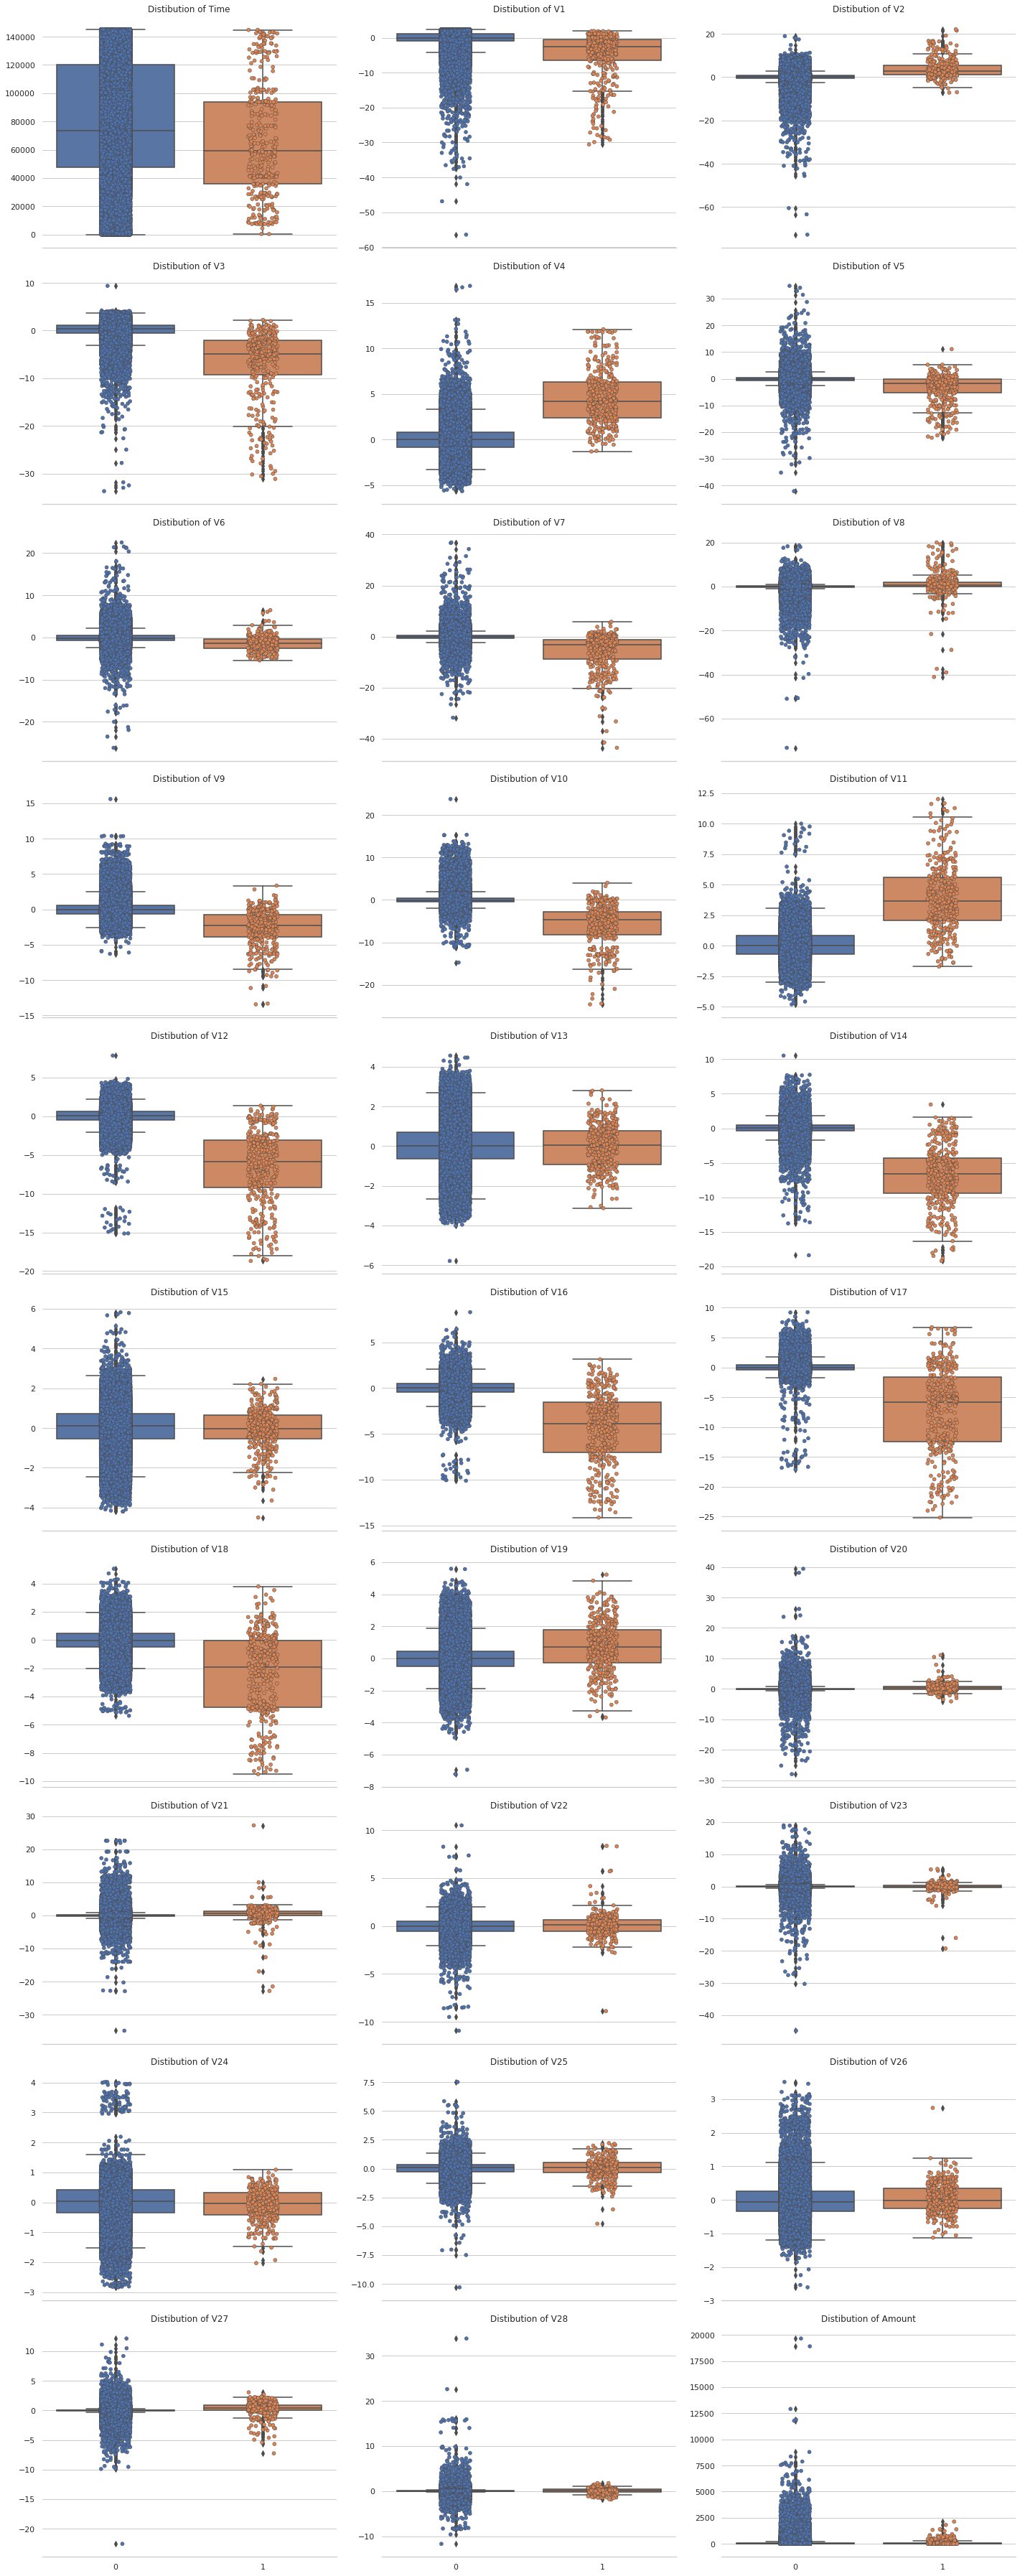

In [10]:
df1 =  df.filter("Class= 1")
df0 = df.filter("Class= 0")
features = df1.columns
n_features = len(features)
#import matplotlib.pyplot as plt
#plt.show()
f, axes = plt.subplots(10, 3, figsize=(20, 50), sharex=True)
sns.despine(left=True)
sns.set(style="whitegrid")

# The amount of space above titles
y_title_margin = 1

i = 0
for j in range(0,10):
    for k in range(0,3):
        sns.boxplot(data=[(np.array(df0.select(features[i]).collect())),(np.array(df1.select(features[i]).collect()))],ax=axes[j, k])
        sns.stripplot(data=[(np.array(df0.select(features[i]).collect())),(np.array(df1.select(features[i]).collect()))], ax=axes[j, k], jitter=True, dodge=True, linewidth=0.5)
        axes[j][k].set_title("Distibution of "+features[i], y = y_title_margin)
        i=i+1

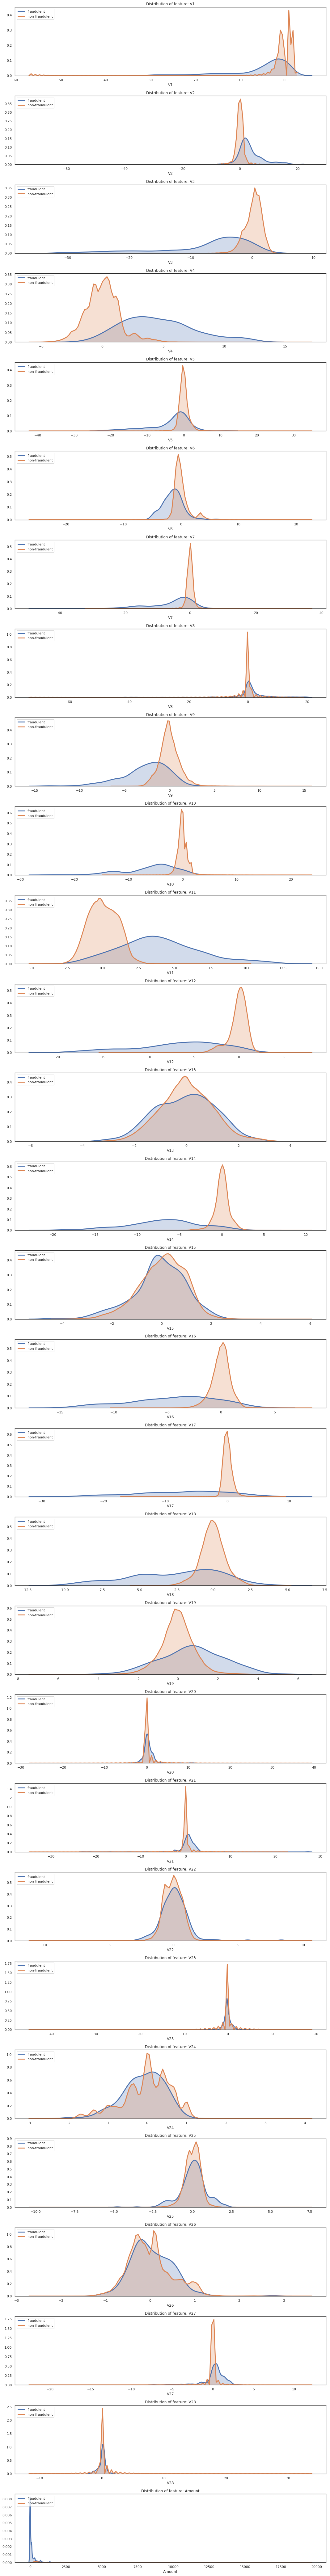

In [5]:
pandas_df = df.toPandas()
labels = [1.0, 0.0]

features=[f for f in pandas_df.columns if 'V' in f]
features = features + ["Amount"]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)

for i in range(len(features)):
    feature = features[i]
    ax = plt.subplot(gs[i])
    for label in labels:
        # Subset to the airline
        subset = pandas_df[pandas_df['Class'] == label]
        sns.distplot(subset[feature], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = label)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='upper left')
    ax.set_title('Distribution of feature: ' + feature)
plt.tight_layout()